In [4]:
# ABOUTME: Corner plot comparison for 2D toy inference task
# ABOUTME: Compares Uniform-trained vs TailedUniform-trained NPE posteriors against reference

import numpy as np
import torch
import random

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [5]:
from toolbox.imports import *
from toolbox.distributions import TailedUniform, IndependentTailedUniform
from toolbox.evaluators import SBIEvaluator

### Load trained posterior ensembles

In [6]:
with open('/home/x-ctirapongpra/scratch/tailed-uniform-sbi/toy-2-dim-models/uniform/posterior.pkl', 'rb') as f:
    posterior_ensemble_old = pickle.load(f)
with open('/home/x-ctirapongpra/scratch/tailed-uniform-sbi/toy-2-dim-models/taileduniform/posterior.pkl', 'rb') as f:
    posterior_ensemble = pickle.load(f)

In [7]:
n_simulations = 4000
n_posterior_samples = 2000

# Parameters ranges
param_1_range = (-1.0, 1.0)
param_2_range = (-1.0, 1.0)
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Scale sigma relative to parameter ranges
sigma_scale = 0.1
sigmas = [sigma_scale * (high - low) for low, high in param_ranges]

# Task setup
task = GaussianLinear(
    dim=2, prior_scale=param_1_width/2
)
simulator = task.get_simulator()

### Select boundary test point at θ=(0.6, 0.6)

This point is 3σ from prior center to stress-test boundary behavior. We want to compare NPE approximations (Uniform/TailedUniform) against analytical reference.

In [8]:
# Training for edge cases
# Define theta_true close to the lower bounds of each parameter

theta_true_edge = np.array([
    param_1_range[1] - 0.4,
    param_2_range[1] - 0.4
])

# Print selected parameter values
print(f"  Param 1: [{param_ranges[0][0]}, {param_ranges[0][1]}] -> selected: {theta_true_edge[0]:.3f}")
print(f"  Param 2: [{param_ranges[1][0]}, {param_ranges[1][1]}] -> selected: {theta_true_edge[1]:.3f}")

  Param 1: [-1.0, 1.0] -> selected: 0.600
  Param 2: [-1.0, 1.0] -> selected: 0.600


In [9]:
# Generate observation using the edge case theta_true
x_obs_edge = simulator(torch.Tensor(theta_true_edge))

# Sample from uniform-trained model
samples_uniform = posterior_ensemble_old.sample((n_posterior_samples,), x_obs_edge)
samples_uniform = samples_uniform.cpu().numpy()

# Sample from TailedUniform-trained model  
samples_tailed_uniform = posterior_ensemble.sample((n_posterior_samples,), x_obs_edge)
samples_tailed_uniform = samples_tailed_uniform.cpu().numpy()

# Get reference posterior for the edge case
xobs_edge = x_obs_edge.clone().detach()
ref_edge = task._get_reference_posterior(observation=xobs_edge)
ref_samples_edge = ref_edge.sample((n_posterior_samples,))

Drawing 558 posterior samples: 100%|██████████| 558/558 [00:00<00:00, 141218.95it/s]


### Compute C2ST and parameter estimates (Table 1)

Quantify distributional similarity and constraining power at boundary.

In [10]:
# Create evaluator and run comparison
evaluator = SBIEvaluator()

samples_dict = {
   'Uniform_NPE': samples_uniform,
   'TailedUniform_NPE': samples_tailed_uniform,
   'RefPosterior': ref_samples_edge.numpy()
}

results = evaluator.compare(samples_dict, theta_true_edge)
evaluator.print_results(results, theta_true_edge)

Method Comparison
--------------------------------------------------

Uniform_NPE:
  TARP: 0.3158
  θ₁: Mean=0.410, Std=0.463
  θ₂: Mean=0.531, Std=0.273
  C2ST: TailedUniform_NPE=0.429, RefPosterior=0.373

TailedUniform_NPE:
  TARP: 0.4526
  θ₁: Mean=0.504, Std=0.535
  θ₂: Mean=0.624, Std=0.294
  C2ST: Uniform_NPE=0.429, RefPosterior=0.442

RefPosterior:
  TARP: 0.3737
  θ₁: Mean=0.642, Std=0.298
  θ₂: Mean=0.594, Std=0.305
  C2ST: Uniform_NPE=0.373, TailedUniform_NPE=0.442


## Single-point corner plot validation (Figure 3)
- Evaluate trained NPE posteriors at boundary test point θ=(0.6, 0.6) to assess boundary performance.
- We find TailedUniform maintains tight concentration while Uniform leaks beyond prior boundary.

Saved plot: toy-2-dim-figures/corner.pdf


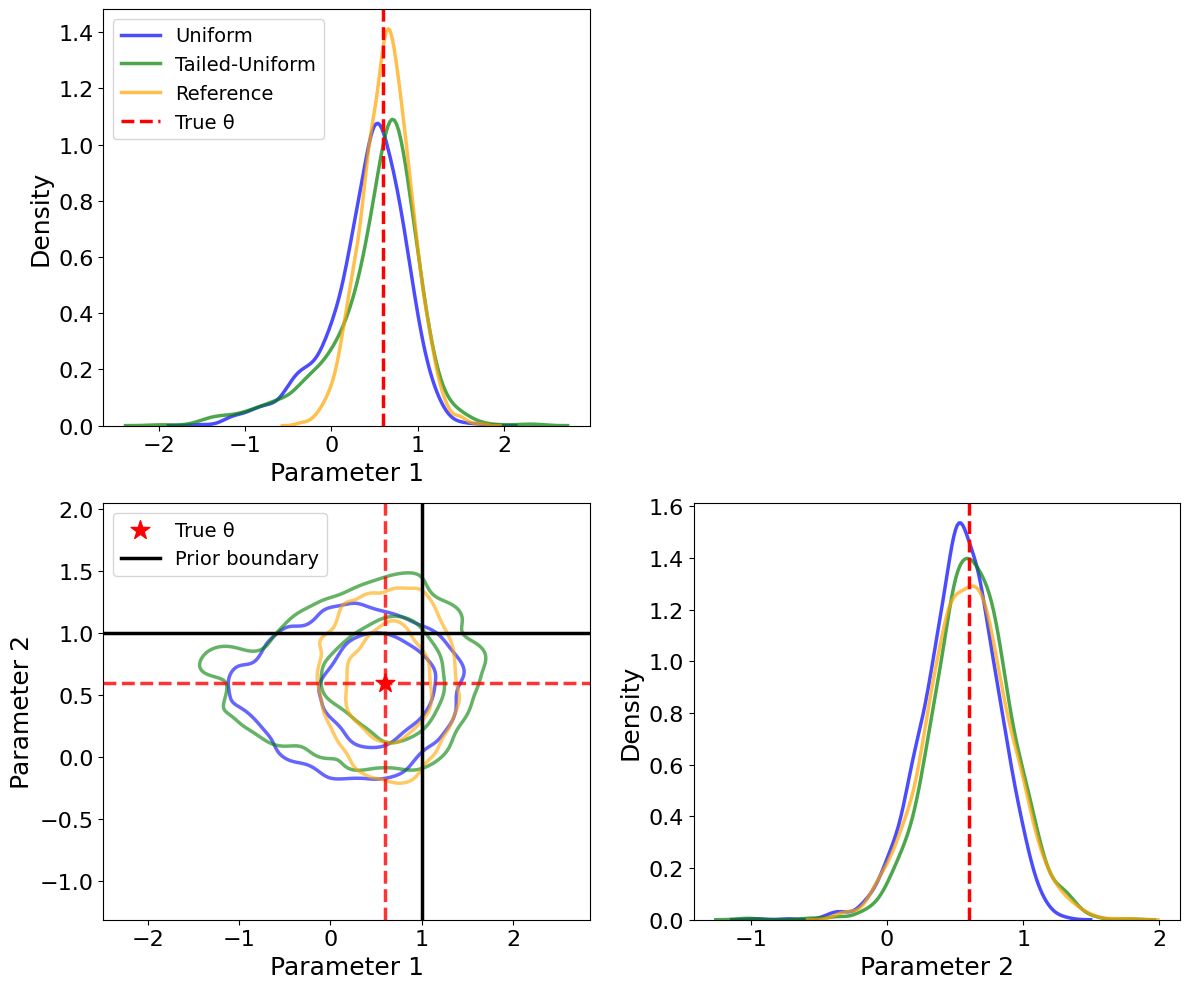

In [11]:
# Create corner plot with larger text
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

methods = ['Uniform', 'Tailed-Uniform', 'Reference']
samples_list = [samples_uniform, samples_tailed_uniform, ref_samples_edge.numpy()]
colors = ['blue', 'green', 'orange']
param_names = ['Parameter 1', 'Parameter 2']

# Increase font sizes
label_fontsize = 18
tick_fontsize = 16
legend_fontsize = 14

# Plot marginal distributions (diagonal)
for i in range(2):
    ax = axes[i, i]
    for method, samples, color in zip(methods, samples_list, colors):
        sns.kdeplot(data=samples[:, i], ax=ax, label=method, color=color, alpha=0.7, linewidth=2.5)
    
    # Add true parameter line
    ax.axvline(theta_true_edge[i], color='red', linestyle='--', linewidth=2.5, label='True θ')
    ax.set_xlabel(param_names[i], fontsize=label_fontsize)
    ax.set_ylabel('Density', fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    if i == 0:
        ax.legend(fontsize=legend_fontsize)

# Plot joint distributions (off-diagonal) - only 68th and 95th percentiles
ax = axes[1, 0]  # Bottom-left for joint distribution
for method, samples, color in zip(methods, samples_list, colors):
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], ax=ax, color=color, alpha=0.6, 
                levels=[0.05, 0.32], label=method, fill=False, linewidths=2.5)

# Add true parameter point
ax.scatter(theta_true_edge[0], theta_true_edge[1], color='red', s=200, 
           marker='*', label='True θ', zorder=10)

# Add red lines to show true parameter values as boundaries
ax.axvline(theta_true_edge[0], color='red', linestyle='--', linewidth=2.5, alpha=0.8)
ax.axhline(theta_true_edge[1], color='red', linestyle='--', linewidth=2.5, alpha=0.8)

# Add black boundary at prior edge (x=1 and y=1)
ax.axvline(1.0, color='black', linestyle='-', linewidth=2.5, alpha=1.0, label='Prior boundary')
ax.axhline(1.0, color='black', linestyle='-', linewidth=2.5, alpha=1.0)

ax.set_xlabel(param_names[0], fontsize=label_fontsize)
ax.set_ylabel(param_names[1], fontsize=label_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.legend(fontsize=legend_fontsize)

# Remove top-right subplot (not needed in corner plot)
axes[0, 1].remove()

plt.tight_layout()
filename = 'toy-2-dim-figures/corner.pdf'
plt.savefig(filename, bbox_inches='tight', dpi=300)
print(f"Saved plot: {filename}")
plt.show()